In [1]:
if False:
    !sudo pip3 install pyro-ppl -q
    !sudo pip3 install seaborn -q
    !wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
    !unzip ml-100k.zip
    !mkdir data
    !mkdir data/100k
    !mv ml-100k/* data/100k

In [2]:
import pyro
import spotlight
import pandas as pd
import seaborn
from spotlight.cross_validation import random_train_test_split
from spotlight.datasets.movielens import get_movielens_dataset
from spotlight.evaluation import rmse_score
from spotlight.factorization.explicit import ExplicitFactorizationModel
import torch

import numpy as np
import matplotlib.pyplot as plt
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
from pyro import plate
import matplotlib.pyplot as plt


from torch import nn

def get_device(device = None):
    if device is not None:
        return torch.device(device)
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    return device
device = get_device("cpu")

In [3]:
from spotlight.interactions import Interactions
import pandas as pd

dat = pd.read_csv("data/100k/u.data", sep ="\t", names = ['userId','itemId','rating','timestamp'])

items = pd.read_csv("data/100k/u.item", sep = "\|", names = ["itemId", "name", "release date", "video release date",
              "IMDb URL", "unknown", "Action", "Adventure", "Animation",
              "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
              "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
              "Thriller", "War", "Western"], engine="python")
categories = ["unknown", "Action", "Adventure", "Animation",
              "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
              "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
              "Thriller", "War", "Western"]
item_genre_vector = np.zeros((items.itemId.max()+1, 19))
item_genre_vector[0,0] = 1
item_genre_vector[1:,:] = items.iloc[:,5:].values
items = items[['itemId','name']]


In [4]:
ds = Interactions(item_ids=torch.tensor(dat.itemId),
            user_ids = torch.tensor(dat.userId),
            ratings=torch.tensor(dat.rating).float(),
            timestamps=torch.tensor(dat.timestamp))

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Total length of dataset 100000
num users: 944, num items: 1683


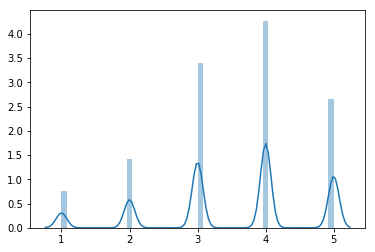

In [5]:
ind2item = {row.itemId : row.name for row in items.itertuples()}

train, test = random_train_test_split(ds)

_ =seaborn.distplot(ds.ratings)
print(f"Total length of dataset {len(ds.ratings)}")
print(f"num users: {ds.num_users}, num items: {ds.num_items}")

## pyro implementation

In [6]:
# TAKING OUT PARAMETERS TO
class SVI_MF_genre(nn.Module):
    """
    A module that contains a model, a guide and a predict function to get expected predictions of user and item ratings."""
    
    def __init__(self, dat, d = 2, use_cuda = True):
        super(SVI_MF_genre, self).__init__()
        self.d = d
        self.num_items = ds.num_items
        self.num_users = ds.num_users
        
        if use_cuda:
            self.cuda()

        
        
    def predict(self, user_ids, item_ids):
        uservec = pyro.param("Z").detach()[user_ids]
        itemvec = pyro.param("V").detach()[item_ids]
        bias = pyro.param("biasPar")
        preds = bias + (uservec * itemvec).sum(1)
        return preds
        
    def model(self, dat):
        mu0 = torch.zeros(self.d).to(device)
        var0 = torch.diag(torch.ones(self.d).to(device))*2
        tri0 = torch.cholesky(var0)
        muZ = pyro.sample("muZ", dist.MultivariateNormal(loc = mu0, scale_tril=tri0))
        
        bias = pyro.sample("bias", dist.Normal(loc = torch.tensor(3.5).to(device), scale = torch.tensor(1.5).to(device)))

        with plate("genres", item_genre_vector.shape[1]):
            muGenre = pyro.sample("muGenre", dist.MultivariateNormal(loc = mu0, scale_tril=tri0))


        with plate("user_loop", dat.num_users):
            Z = pyro.sample(f"z_", dist.MultivariateNormal(muZ, scale_tril=tri0))

        genre_mat = torch.tensor(item_genre_vector).to(device).float()
        genre_sums = genre_mat.sum(1, keepdim=True)
        muItems = genre_mat.matmul(muGenre)/genre_sums
            
        with plate("item_loop", dat.num_items) as ind:
            V = pyro.sample(f"v_", dist.MultivariateNormal(muItems, 
                                                           scale_tril=tri0))


        with plate("data_loop", size = len(dat.ratings)) as k:
            z = Z[dat.user_ids[k]]
            v = V[dat.item_ids[k]]
            score = z.mul(v).sum(1)
            r = dat.ratings[k]
            distrR = dist.Normal(loc = bias + score, scale = 0.5)
            pyro.sample(f"obs",  distrR, obs=r)
            
    def guide(self, dat):


        ## GLOBAL RVs ##
        biasPar = pyro.param("biasPar", torch.tensor(3.0).to(device))
        biasVar = pyro.param("biasVar", torch.tensor(1.0).to(device), constraint = constraints.positive)
        bias = pyro.sample("bias", dist.Normal(loc = biasPar, scale = biasVar))        

        ## USER RVs ##
        muZpar = pyro.param("muZpar", (torch.rand(self.d)-0.5).to(device))
        global_triZ = pyro.param("triangZpar", 
                      torch.diag(0.5*torch.ones(self.d)).to(device), 
                      constraint = constraints.lower_cholesky)
        muZ = pyro.sample("muZ", dist.MultivariateNormal(loc = muZpar, scale_tril = global_triZ))
        user_var = pyro.param("user_var_factor", 
                              (torch.rand(self.num_users)+0.5).to(device), 
                              constraint = constraints.positive)
        
        D_Z = torch.diag(torch.ones(self.d).to(device)).unsqueeze(0).repeat(len(user_var),1,1)*user_var.unsqueeze(1).unsqueeze(1)
        triZ = global_triZ.matmul(D_Z)
        
        with plate("user_loop", dat.num_users):
            Z = pyro.param("Z", (torch.rand(dat.num_users, self.d)-0.5).to(device))
            pyro.sample(f"z_", dist.MultivariateNormal(Z, scale_tril=triZ))
            

        ##  GENRE RANDOM VARIABLES ##
        # Model as full multivariate normals
        triGenre = pyro.param("triangGENREpar", 
                      torch.diag(torch.ones(self.d)).unsqueeze(0).repeat(19,1,1).to(device), 
                      constraint = constraints.lower_cholesky)
        muGENREpar = pyro.param("muGENREpar", (torch.rand((19, self.d))-0.5).to(device))
        with plate("genres", item_genre_vector.shape[1]):
            muGenre = pyro.sample("muGenre", dist.MultivariateNormal(loc = muGENREpar, scale_tril= triGenre))

        ### ITEMS RVs ###
        # Each item has a factor it multiplies L with on diagonal. Inspiration: covar = L D L^t = (L D^0.5) (L D^0.5)ˆt
        # item_var is the D**2
        global_triV = pyro.param("triangVpar", 
                      torch.diag(0.5*torch.ones(self.d)).to(device), 
                      constraint = constraints.lower_cholesky)

        item_var = pyro.param("item_var_factor", (torch.rand(self.num_items)+0.5).to(device),
                              constraint = constraints.positive)
        D_V = torch.diag(torch.ones(self.d).to(device)).unsqueeze(0).repeat(len(item_var),1,1)*item_var.unsqueeze(1).unsqueeze(1)
        triV = global_triV.matmul(D_V)
        
        ## item latent vectors
        with plate("item_loop", dat.num_items):
            V = pyro.param("V", (torch.rand(dat.num_items, self.d)-0.5).to(device))
            pyro.sample(f"v_", dist.MultivariateNormal(V, scale_tril=triV))
            

In [7]:
def rmse_score(model, test, cold_start = None):
    predictions = model.predict(test.user_ids, test.item_ids)
    errors = ((test.ratings - predictions)**2)
    if cold_start is not None:
        ids, item_counts = np.unique(test.item_ids.numpy(), return_counts=True)
        cold_start_items = ids[item_counts<cold_start]
        use = np.isin(test.item_ids, cold_start_items)
        return np.sqrt(errors.cpu().detach().numpy()[use].mean())
    else:
        return torch.sqrt(errors.mean()).item()

In [8]:
device = get_device("cuda")
svi_mf = SVI_MF_genre(ds, d=2).to(device)
for dat in [train, test]:
    dat.ratings = dat.ratings.to(device)

In [9]:
%%time
n_steps = 201
pyro.clear_param_store()

# set up the optimizer
adam_params = {"lr": 0.03}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(svi_mf.model, svi_mf.guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
    loss = svi.step(train)

    if step%10== 0:
        # RMSE
        rmse_test = rmse_score(svi_mf, test)
        rmse_cold = rmse_score(svi_mf, test, cold_start=5)
        print(f"step: {step} \t loss: {loss:.0f} \t test-rmse: {rmse_test:.2f} \t cold-rmse: {rmse_cold:.2f}")

step: 0 	 loss: 848203 	 test-rmse: 1.24 	 cold-rmse: 1.27
step: 10 	 loss: 236395 	 test-rmse: 1.19 	 cold-rmse: 1.28
step: 20 	 loss: 230129 	 test-rmse: 1.15 	 cold-rmse: 1.31
step: 30 	 loss: 314980 	 test-rmse: 1.13 	 cold-rmse: 1.33
step: 40 	 loss: 211555 	 test-rmse: 1.09 	 cold-rmse: 1.32
step: 50 	 loss: 202829 	 test-rmse: 1.05 	 cold-rmse: 1.27
step: 60 	 loss: 212322 	 test-rmse: 1.02 	 cold-rmse: 1.24
step: 70 	 loss: 244588 	 test-rmse: 1.01 	 cold-rmse: 1.23
step: 80 	 loss: 222123 	 test-rmse: 1.00 	 cold-rmse: 1.21
step: 90 	 loss: 176226 	 test-rmse: 1.00 	 cold-rmse: 1.21
step: 100 	 loss: 188691 	 test-rmse: 0.97 	 cold-rmse: 1.20
step: 110 	 loss: 162525 	 test-rmse: 0.98 	 cold-rmse: 1.20
step: 120 	 loss: 192429 	 test-rmse: 0.96 	 cold-rmse: 1.18
step: 130 	 loss: 158899 	 test-rmse: 0.96 	 cold-rmse: 1.17
step: 140 	 loss: 163397 	 test-rmse: 0.96 	 cold-rmse: 1.16
step: 150 	 loss: 156604 	 test-rmse: 0.96 	 cold-rmse: 1.16
step: 160 	 loss: 166345 	 test-rms

## Print uncertainty factors vs number of activity on user and items

User activity/uncertainty correlation: -0.54


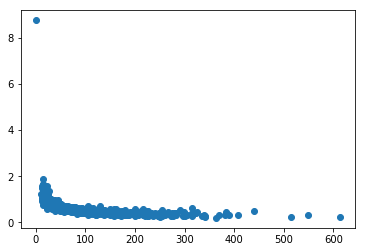

Item activity/uncertainty correlation: -0.43


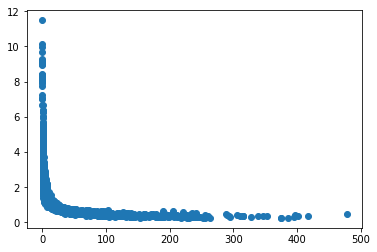

In [10]:
def get_counts(sequence, num):
    ids, id_count = np.unique(sequence, return_counts=True)
    counts = np.zeros(num)
    counts[ids] = id_count
    return counts

user_counts = get_counts(train.user_ids, train.num_users)#[1:]
user_factors = pyro.param("user_var_factor").detach().cpu().numpy()#[1:]
print(f"User activity/uncertainty correlation: {np.corrcoef(user_factors, user_counts)[1,0]:.2f}")
_ = plt.plot(user_counts, user_factors, "o")
plt.show()

item_counts = get_counts(train.item_ids, train.num_items)
item_factors = pyro.param("item_var_factor").detach().cpu().numpy()
print(f"Item activity/uncertainty correlation: {np.corrcoef(item_factors, item_counts)[1,0]:.2f}")
_ = plt.plot(item_counts, item_factors, "o")
plt.show()

# Plot distribution of vectors

Random users:


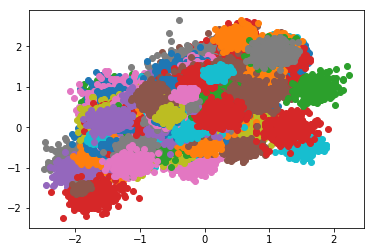

Most and least seen user:


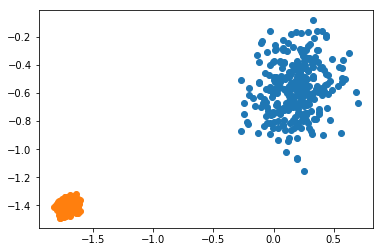

In [12]:
def plot_distr_of_users(u):
    u_means = pyro.param("Z")[u,]
    global_triZ = pyro.param("triangZpar")
    user_var = pyro.param("user_var_factor")[u]

    D_Z = torch.diag(torch.ones(svi_mf.d).to(device)).unsqueeze(0).repeat(len(user_var),1,1)*user_var.unsqueeze(1).unsqueeze(1)
    triZ = global_triZ.matmul(D_Z)
    
    user_distr = torch.distributions.MultivariateNormal(u_means, scale_tril = triZ)

    samples = user_distr.sample(torch.tensor([300])).cpu().numpy()
    for u in range(len(u)):
        plt.plot(samples[:,u,0], samples[:,u,1], "o")
        

print("Random users:")
u = torch.randint(low=1, high=train.num_users, size = (500,))
plot_distr_of_users(u)
plt.show()

u = np.array([user_counts.argsort()[1], user_counts.argmax()])
print("Most and least seen user:")
plot_distr_of_users(u)

Random items:


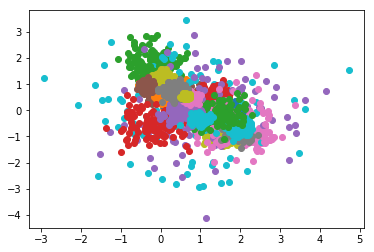

Most and least seen item:


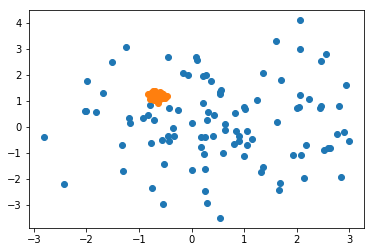

In [13]:
def plot_distr_of_items(u):
    u_means = pyro.param("V")[u,]
    global_triZ = pyro.param("triangVpar")
    user_var = pyro.param("item_var_factor")[u]

    D_Z = torch.diag(torch.ones(svi_mf.d).to(device)).unsqueeze(0).repeat(len(user_var),1,1)*user_var.unsqueeze(1).unsqueeze(1)
    triZ = global_triZ.matmul(D_Z)
    user_distr = torch.distributions.MultivariateNormal(u_means, scale_tril=triZ)

    samples = user_distr.sample(torch.tensor([100])).cpu().numpy()
    for u in range(len(u)):
        plt.plot(samples[:,u,0], samples[:,u,1], "o")

print("Random items:")
u = torch.randint(low=1, high=train.num_items, size = (30,))
plot_distr_of_items(u)
plt.show()

u = np.array([item_counts.argsort()[1], item_counts.argmax()])
print("Most and least seen item:")
plot_distr_of_items(u)

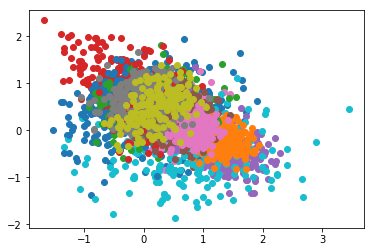

In [14]:
triGenre = pyro.param("triangGENREpar")
muGENREpar = pyro.param("muGENREpar")
cat_distr = torch.distributions.MultivariateNormal(muGENREpar, scale_tril=triGenre)
samples = cat_distr.sample(torch.tensor([200])).cpu().numpy()
for u in range(19):
    plt.plot(samples[:,u,0], samples[:,u,1], "o")

In [17]:
X = muGENREpar.detach().cpu().numpy()
norm = np.sqrt((X**2).sum(1))
for i in range(18):
    scores = (X[i,]*X).sum(1) / norm[i] / norm
    topK = np.argsort(scores)[::-1]
    most_sim = ", ".join([categories[k] for k in topK[:3]])
    print(categories[i],": ", most_sim)

unknown :  unknown, Crime, Adventure
Action :  Action, Children's, Horror
Adventure :  Adventure, Drama, unknown
Animation :  Animation, Film-Noir, War
Children's :  Children's, Action, Horror
Comedy :  Comedy, Thriller, Horror
Crime :  Crime, Romance, Sci-Fi
Documentary :  Documentary, Musical, Mystery
Drama :  Drama, Adventure, unknown
Fantasy :  Fantasy, Children's, Action
Film-Noir :  Film-Noir, Animation, War
Horror :  Horror, Comedy, Action
Musical :  Musical, Documentary, Mystery
Mystery :  Mystery, Documentary, Musical
Romance :  Romance, Sci-Fi, Crime
Sci-Fi :  Sci-Fi, Romance, Crime
Thriller :  Thriller, Comedy, Horror
War :  War, Mystery, Documentary
